In [4]:
import numpy as np
old = np.load;np.load = lambda *a,**k: old(*a,**k,allow_pickle=True)

from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

np.load = old;del(old)

In [6]:
# decoding newswires back to ext
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode(newswire):
    return ' '.join(reverse_word_index.get(i-3, '?') for i in newswire)

decode(train_data[0])

557056/550378 [==============================] - 0s 0us/step


'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [11]:
# encoding the data
def vectorize_sequences(sequences, dimension=10000):
    result = np.zeros((len(sequences), dimension))
    for i, seq in enumerate(sequences):
        result[i, seq] = 1
    return result

X_train = vectorize_sequences(train_data)
X_test = vectorize_sequences(test_data)

print(X_train.shape)
print(X_test.shape)

(8982, 10000)
(2246, 10000)


In [26]:
# encoding labels
print(train_labels)

from keras.utils.np_utils import to_categorical
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)

# alternatively y_train=vectorize_sequences(train_labels, dimension=46)

print(y_train.shape)
print(y_train)

[ 3  4  3 ... 25  3 25]
(8982, 46)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [44]:
# model definition
from keras import models, layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

# compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

# setting aside a validation set
def split(seq, at):
    return seq[:at], seq[at:]

X_val, X_train_p = split(X_train, 1000)
y_val, y_train_p = split(y_train, 1000)

In [46]:
# training the model
%time history = model.fit(X_train_p, y_train_p, epochs=20, batch_size=512, validation_data=(X_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 129us/step - loss: 0.1125 - acc: 0.9585 - val_loss: 1.0888 - val_acc: 0.7940
Epoch 2/20
7982/7982 [==============================] - 1s 129us/step - loss: 0.1070 - acc: 0.9590 - val_loss: 1.1299 - val_acc: 0.7950
Epoch 3/20
7982/7982 [==============================] - 1s 129us/step - loss: 0.1076 - acc: 0.9597 - val_loss: 1.1341 - val_acc: 0.7900
Epoch 4/20
7982/7982 [==============================] - 1s 129us/step - loss: 0.1107 - acc: 0.9564 - val_loss: 1.1234 - val_acc: 0.7880
Epoch 5/20
7982/7982 [==============================] - 1s 129us/step - loss: 0.1033 - acc: 0.9588 - val_loss: 1.1538 - val_acc: 0.7890
Epoch 6/20
7982/7982 [==============================] - 1s 129us/step - loss: 0.1042 - acc: 0.9563 - val_loss: 1.2321 - val_acc: 0.7790
Epoch 7/20
7982/7982 [==============================] - 1s 128us/step - loss: 0.1023 - acc: 0.9572 - val_loss: 1.1419 - val_acc: 0.7990


In [50]:
history.history

{'val_loss': [1.0888455066680909,
  1.129935311317444,
  1.1340545988082886,
  1.1234179668426514,
  1.1538491115570069,
  1.2320846462249755,
  1.1418742828369142,
  1.2422743072509765,
  1.1808211069107055,
  1.2680802040100099,
  1.179520887374878,
  1.2098861341476441,
  1.2007069540023805,
  1.2847127714157105,
  1.2350819911956787,
  1.2231952772140502,
  1.229095458984375,
  1.2243659925460815,
  1.223929970741272,
  1.28755287361145],
 'val_acc': [0.7939999990463257,
  0.7949999918937684,
  0.7900000123977661,
  0.7879999856948853,
  0.7889999942779541,
  0.7789999856948853,
  0.7989999966621399,
  0.7769999976158142,
  0.7879999942779541,
  0.7849999856948853,
  0.7990000100135803,
  0.7879999904632569,
  0.7900000076293945,
  0.7779999928474426,
  0.7889999856948853,
  0.7970000100135803,
  0.7979999966621399,
  0.7860000014305115,
  0.7919999966621399,
  0.773999988079071],
 'loss': [0.11253939026864482,
  0.10698078573870198,
  0.10759720596058032,
  0.11069917257299282,
  

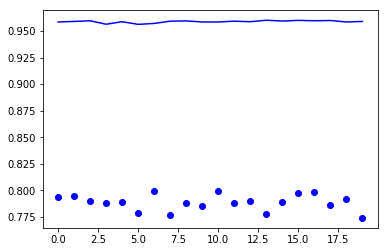

In [59]:
from matplotlib import pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(acc, 'b')
plt.plot(val_acc, 'bo')

In [60]:
# retraining the model from scratch
# model definition
from keras import models, layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

# compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model.fit(X_train, y_train, epochs=9, batch_size=512)

result = model.evaluate(X_test, y_test)

Epoch 1/9
8982/8982 [==============================] - 2s 184us/step - loss: 2.6809 - acc: 0.5049
Epoch 2/9
8982/8982 [==============================] - 1s 120us/step - loss: 1.4175 - acc: 0.7070
Epoch 3/9
8982/8982 [==============================] - 1s 120us/step - loss: 1.0252 - acc: 0.7853
Epoch 4/9
8982/8982 [==============================] - 1s 119us/step - loss: 0.7960 - acc: 0.8343
Epoch 5/9
8982/8982 [==============================] - 1s 119us/step - loss: 0.6293 - acc: 0.8681
Epoch 6/9
8982/8982 [==============================] - 1s 119us/step - loss: 0.5042 - acc: 0.8931
Epoch 7/9
8982/8982 [==============================] - 1s 118us/step - loss: 0.4051 - acc: 0.9156
Epoch 8/9
8982/8982 [==============================] - 1s 118us/step - loss: 0.3341 - acc: 0.9300
Epoch 9/9
2246/2246 [==============================] - 0s 110us/step


In [63]:
print(model.metrics_names)
print(result)

['loss', 'acc']
[0.9640878832775466, 0.7894033838199487]


In [71]:
predictions = model.predict(X_test)
print(np.argmax(predictions, axis=1))

[ 3 10  1 ...  3  4  1]


In [80]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression().fit(X_train, train_labels)

In [82]:
logistic.score(X_train, train_labels)

0.9668225339568025

In [83]:
logistic.score(X_test, test_labels)

0.7978628673196795